## Imports

In [2]:
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import importlib

### Loading Repo

In [3]:
!git clone -b talib-1 http://github.com/Zapy67/ATML-PA-2

fatal: destination path 'ATML-PA-2' already exists and is not an empty directory.


In [7]:
!git pull http://github.com/Zapy67/ATML-PA-2 talib-1

remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 7 (delta 5), reused 7 (delta 5), pack-reused 0 (from 0)
Unpacking objects: 100% (7/7), 322.92 KiB | 1.20 MiB/s, done.
From http://github.com/Zapy67/ATML-PA-2
 * branch            talib-1    -> FETCH_HEAD
Updating 63db16a..6cd874b
Fast-forward
 DANN & CDAN/CDAN.py    | 561 +++++++++++++---------------
 DANN & CDAN/DANN.py    |   2 +-
 DANN & CDAN/cdan.ipynb | 997 +++++++++++++++++++++++++++++++++++++++++++++++++
 DANN & CDAN/dann.ipynb | 557 ++++++++++++---------------
 4 files changed, 1487 insertions(+), 630 deletions(-)


In [6]:
%cd ATML-PA-2/

/kaggle/working/ATML-PA-2


In [8]:
%cd "DANN & CDAN"

/kaggle/working/ATML-PA-2/DANN & CDAN


In [5]:
!ls

ATML-PA-2


In [9]:
from utils.dataset import MEAN, STD, OfficeHomeDataset
import utils
import os
from torchvision.models import ResNet50_Weights

importlib.reload(utils)

<module 'utils' from '/kaggle/working/ATML-PA-2/DANN & CDAN/utils/__init__.py'>

### Loading Dataset

In [10]:
root_dir = '/kaggle/input/officehome/OfficeHomeDataset_10072016'
csv_file = '/kaggle/input/officehome/OfficeHomeDataset_10072016/ImageInfo.csv'

In [11]:
transform = ResNet50_Weights.IMAGENET1K_V1.transforms()
classes = os.listdir(f"{root_dir}/Art")

In [12]:
sources = ["Art", "Real World", "Product"]
target = ["Clipart"]
source_ds = utils.dataset.OfficeHomeDataset(root_dir, csv_file, sources, transform)
target_ds = utils.dataset.OfficeHomeDataset(root_dir, csv_file, target, transform)

(15913, 2)
                                           name  \
0  D:/Dataset10072016/Art/Alarm_Clock/00001.jpg   
1  D:/Dataset10072016/Art/Alarm_Clock/00002.jpg   
2  D:/Dataset10072016/Art/Alarm_Clock/00003.jpg   
3  D:/Dataset10072016/Art/Alarm_Clock/00004.jpg   
4  D:/Dataset10072016/Art/Alarm_Clock/00005.jpg   

                                                link  
0  http://img03.deviantart.net/6533/i/2012/052/0/...  
1  http://img07.deviantart.net/a073/i/2011/214/5/...  
2  http://img08.deviantart.net/955f/i/2011/226/b/...  
3  http://img06.deviantart.net/d6fe/i/2006/177/7/...  
4  http://orig04.deviantart.net/7945/f/2013/237/b...  
(15913, 2)
                                           name  \
0  D:/Dataset10072016/Art/Alarm_Clock/00001.jpg   
1  D:/Dataset10072016/Art/Alarm_Clock/00002.jpg   
2  D:/Dataset10072016/Art/Alarm_Clock/00003.jpg   
3  D:/Dataset10072016/Art/Alarm_Clock/00004.jpg   
4  D:/Dataset10072016/Art/Alarm_Clock/00005.jpg   

                                  

In [13]:
source_loader = DataLoader(source_ds, batch_size=32, shuffle=True, num_workers=2)
target_loader = DataLoader(target_ds, batch_size=32, shuffle=True, num_workers=2)

In [14]:
def denormalize(img_tensor, mean=MEAN, std=STD):
    """Undo normalization on a single image tensor (C,H,W) → numpy (H,W,C) in [0,1]."""
    img = img_tensor.clone().cpu()
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    img = img * std + mean
    img = img.permute(1, 2, 0).clamp(0, 1)
    return img.numpy()

In [15]:
def show_images_from_dataset(dataset, n=8, title="Sample Images"):
    """
    Displays 'n' random images from the OfficeHomeDataset with class names.
    """
    plt.figure(figsize=(3 * n, 3))
    indices = torch.randperm(len(dataset))[:n]

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = denormalize(img)
        label_name = list(dataset.class_to_idx.keys())[label]

        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(label_name, fontsize=9)
        plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


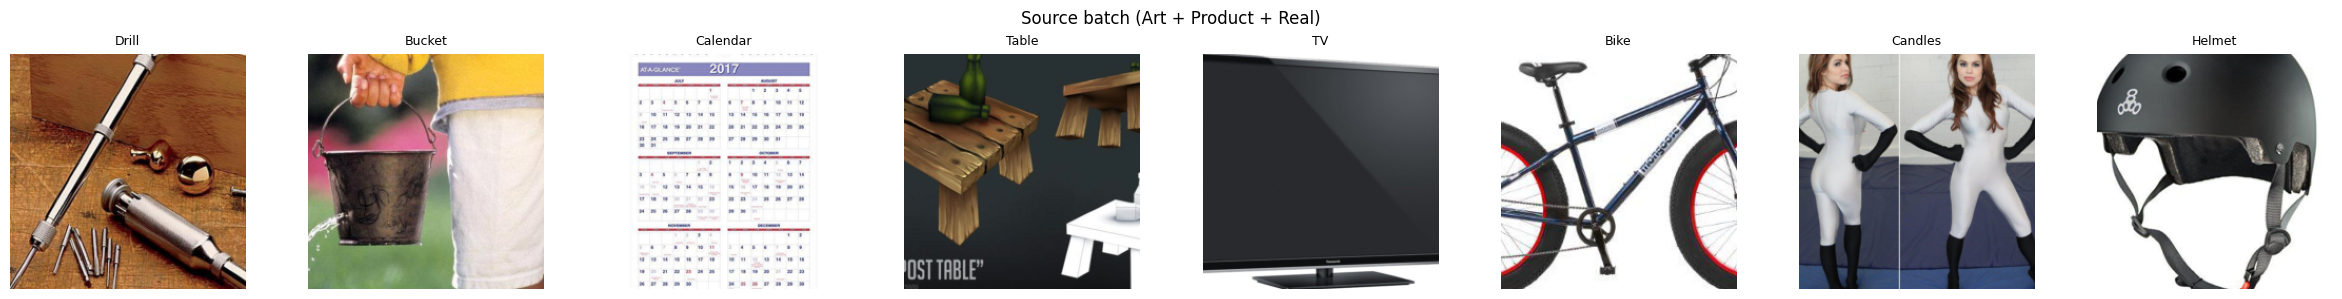

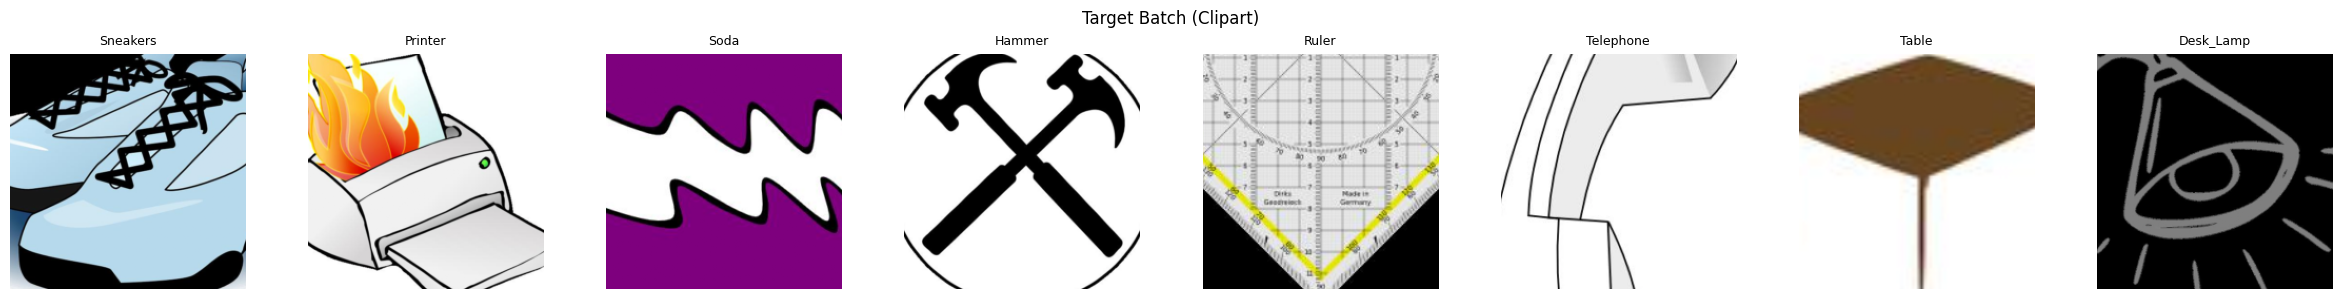

In [16]:
# show source images
show_images_from_dataset(source_ds, title="Source batch (Art + Product + Real)")
# show target images
show_images_from_dataset(target_ds, title="Target Batch (Clipart)")

## CDAN Training

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
import CDAN as cdan
importlib.reload(cdan)
importlib.reload(utils.dataset)

<module 'utils.dataset' from '/kaggle/working/ATML-PA-2/DANN & CDAN/utils/dataset.py'>

In [19]:
from utils.dataset import FeatureTensorDataset
from torchvision.models import resnet50

In [20]:
import torch.nn as nn
class RestWrapper(nn.Module):
    """Wrap the `truncate_from(resnet, 'layer3')` module so it returns (B, D)
       and exposes output_dim attribute expected by DANN class."""
    def __init__(self, rest_module, output_dim=1024):
        super().__init__()
        self.rest = rest_module
        self.output_dim = output_dim

    def forward(self, featmap):
        out = self.rest(featmap)
        if out.dim() == 4:
            out = torch.flatten(out, 1)
        elif out.dim() == 2:
            # already flattened
            pass
        else:
            # keep guard
            out = out.view(out.size(0), -1)
        return out

In [21]:
def truncate_up_to(resnet: nn.Module, layer_name: str) -> nn.Sequential:
    seq = nn.Sequential()
    for name, module in resnet.named_children():
        seq.add_module(name, module)
        if name == layer_name:
            break
    return seq

def truncate_from(resnet: nn.Module, layer_name: str) -> nn.Sequential:
    seen = False
    seq = nn.Sequential()
    for name, module in resnet.named_children():
        if seen and name != 'fc':    # exclude final fc
            seq.add_module(name, module)
        if name == layer_name:
            seen = True
    return seq

def freeze_until(resnet: nn.Module, layer_name: str):
    freeze = True
    for name, module in resnet.named_children():
        if freeze:
            for p in module.parameters():
                p.requires_grad = False
        if name == layer_name:
            freeze = False

In [22]:
base_resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
freeze_until(base_resnet, 'layer3')

In [23]:
cache_source = utils.dataset.FeatureTensorDataset(dataset=source_ds, base_model=base_resnet, layer_name='layer3', device=device, batch_size=32, num_workers=2)
cache_target = utils.dataset.FeatureTensorDataset(dataset=target_ds, base_model=base_resnet, layer_name='layer3', device=device, batch_size=32, num_workers=2)

Precomputing up to layer3: 100%|██████████| 137/137 [00:32<00:00,  4.17it/s]


In [24]:
rest = truncate_from(base_resnet, 'layer3')
rest_wrapper = RestWrapper(rest, output_dim=2048).to(device)

In [25]:
model = cdan.CDAN(num_classes=65, resnet=rest_wrapper)

In [26]:
src_loader = DataLoader(cache_source, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
tgt_loader = DataLoader(cache_target, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

In [27]:
trainer = cdan.CDANTrainer(
        model=model,
        device=device,
        learning_rate=1e-4,
        weight_decay=5e-4,
        gamma=5.0
    )

In [28]:
trainer.train(source_loader=src_loader, target_loader=tgt_loader, num_epochs=10)

Epoch 1/10: 100%|██████████| 351/351 [01:02<00:00,  5.63it/s]


KeyError: 'target_class_loss'


=== SOURCE REPORT ===
              precision    recall  f1-score   support

 Alarm_Clock     0.9876    1.0000    0.9938       239
    Backpack     0.9835    1.0000    0.9917       239
   Batteries     1.0000    0.9935    0.9967       153
         Bed     1.0000    0.9940    0.9970       166
        Bike     1.0000    1.0000    1.0000       218
      Bottle     0.9917    1.0000    0.9958       239
      Bucket     0.9940    0.9940    0.9940       167
  Calculator     1.0000    1.0000    1.0000       187
    Calendar     1.0000    0.9941    0.9970       169
     Candles     1.0000    1.0000    1.0000       231
       Chair     0.9962    0.9811    0.9885       264
  Clipboards     0.9935    0.9935    0.9935       155
    Computer     0.9652    0.9510    0.9580       204
       Couch     0.9855    1.0000    0.9927       204
    Curtains     0.9947    1.0000    0.9973       188
   Desk_Lamp     0.9881    0.9881    0.9881       168
       Drill     1.0000    1.0000    1.0000       133
    

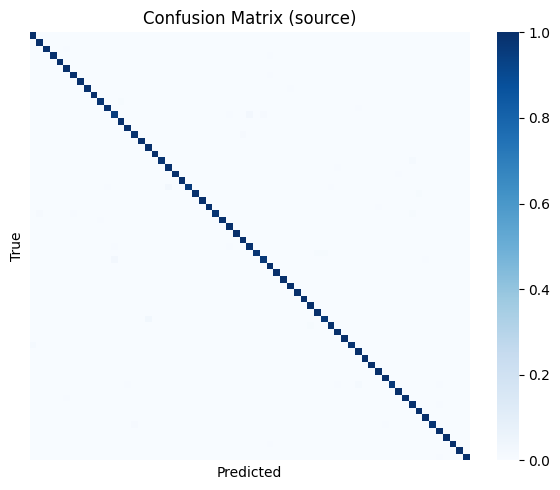

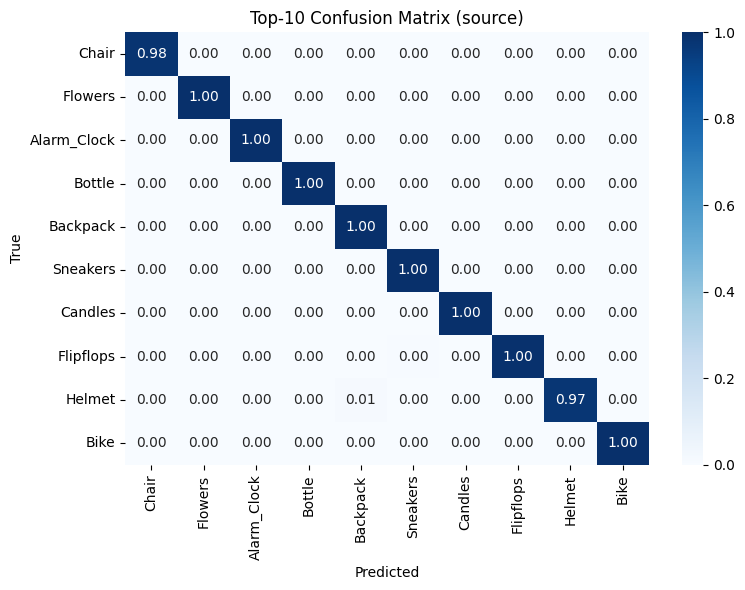


=== TARGET REPORT ===
              precision    recall  f1-score   support

 Alarm_Clock     0.7368    0.7000    0.7179        60
    Backpack     0.5692    0.6607    0.6116        56
   Batteries     0.6250    0.2344    0.3409        64
         Bed     0.8378    0.3163    0.4593        98
        Bike     0.9610    0.7475    0.8409        99
      Bottle     0.3016    0.3838    0.3378        99
      Bucket     0.3111    0.3836    0.3436        73
  Calculator     0.5570    0.9565    0.7040        46
    Calendar     0.6579    0.6410    0.6494        78
     Candles     0.3452    0.2929    0.3169        99
       Chair     0.7818    0.4343    0.5584        99
  Clipboards     0.1316    0.2500    0.1724        40
    Computer     0.5283    0.2828    0.3684        99
       Couch     0.5405    0.6250    0.5797        64
    Curtains     0.7347    0.8571    0.7912        42
   Desk_Lamp     0.0920    0.1951    0.1250        41
       Drill     0.8261    0.3958    0.5352        48
    

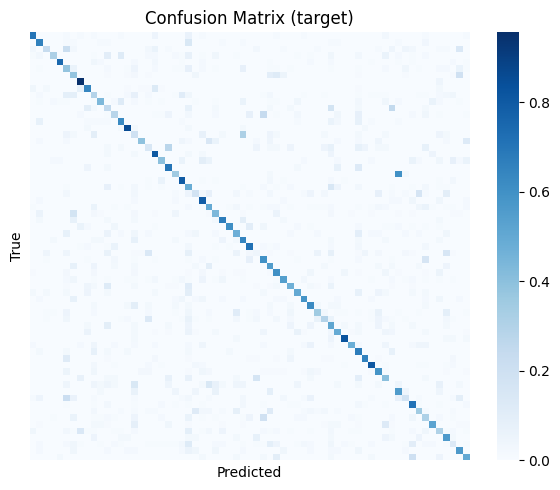

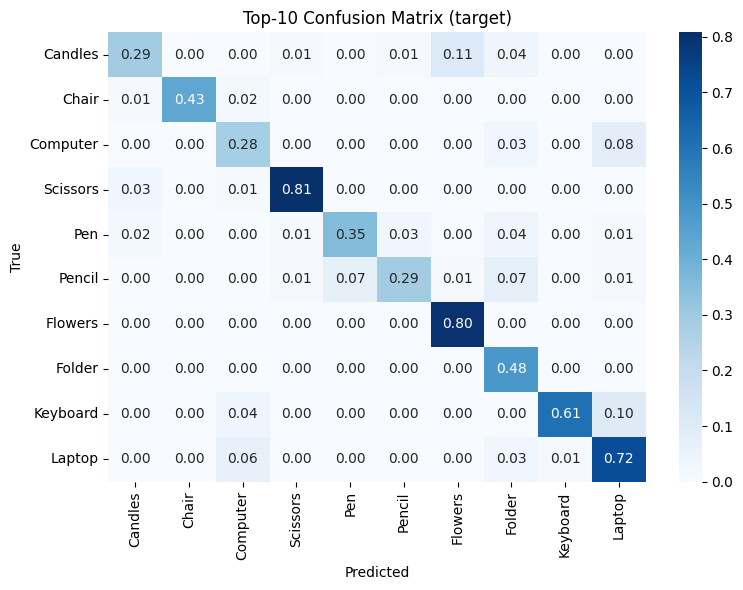

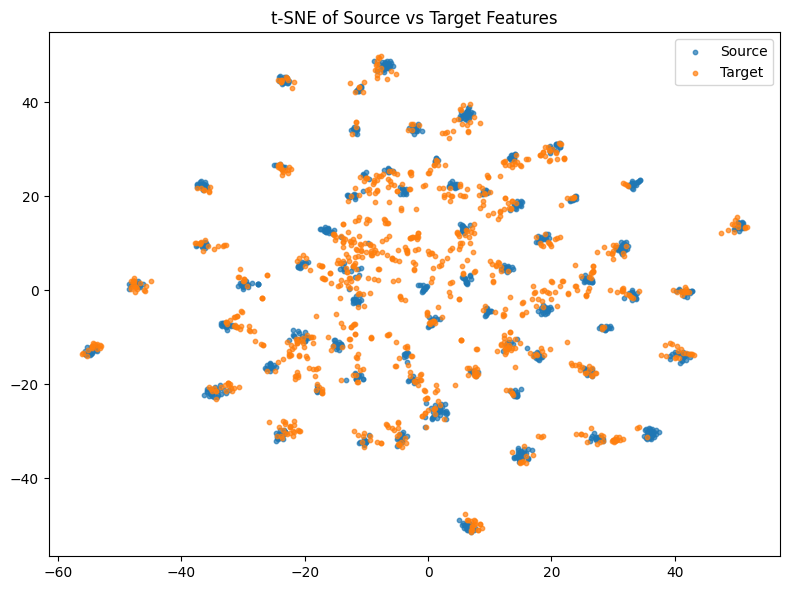

{'tsne': array([[-54.899208 , -13.276164 ],
        [  1.1516821, -24.33397  ],
        [-23.824457 ,  26.51427  ],
        ...,
        [-23.759377 ,  44.699806 ],
        [  6.961131 , -51.46365  ],
        [ -2.5679505,  34.151176 ]], dtype=float32),
 'source': {'report': '              precision    recall  f1-score   support\n\n Alarm_Clock     0.9876    1.0000    0.9938       239\n    Backpack     0.9835    1.0000    0.9917       239\n   Batteries     1.0000    0.9935    0.9967       153\n         Bed     1.0000    0.9940    0.9970       166\n        Bike     1.0000    1.0000    1.0000       218\n      Bottle     0.9917    1.0000    0.9958       239\n      Bucket     0.9940    0.9940    0.9940       167\n  Calculator     1.0000    1.0000    1.0000       187\n    Calendar     1.0000    0.9941    0.9970       169\n     Candles     1.0000    1.0000    1.0000       231\n       Chair     0.9962    0.9811    0.9885       264\n  Clipboards     0.9935    0.9935    0.9935       155\n    Co

In [ ]:
trainer.analysis(src_loader, tgt_loader, class_names= source_ds.classes,random_state=42)